In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures,FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression,ElasticNet,Lasso,SGDRegressor
from sklearn.svm import LinearSVR

In [2]:
# ignore scikit-learn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
# create table (Attributes x Label) that uses n points for predicting the next value of series x
def prepareTrain(x, n):
    ret = []
    for i in range(len(x) - n):
        aux = []
        for j in range(n + 1):
            aux.append(x[i + j])
        ret.append(aux)
    return np.array(ret)

In [4]:
# calculate average error for the next point prediction
def calculateError(model, series, n):
    x = prepareTrain(series, n)
    
    error = 0
    train_data = []
    train_label = []
    cnt = 0
    for i in range(len(x) - 1):
        train_data.append(x[i,:n])
        train_label.append(x[i,n])
        
        reg = model.fit(train_data, train_label)
        yPredicted = reg.predict([x[i + 1,:n]])[0]
        
        error += (i + 1) * abs(yPredicted - x[i + 1,n])
        cnt += (i + 1)
        
    return error / float(cnt)

In [5]:
# load dataset
dataset = pd.read_csv("time_series_19-covid-Confirmed-3-22.csv")
allSeries = dict()

# prepare Italy data
seriesItaly = dataset.loc[dataset['Country/Region'] == 'Italy']
seriesItaly = np.sum(np.array(seriesItaly.values)[:,4:], axis=0)
seriesItaly = seriesItaly[31:] # remove zeros (9)
allSeries['Italy'] = seriesItaly

# prepare Spain data
seriesSpain = dataset.loc[dataset['Country/Region'] == 'Spain']
seriesSpain = np.sum(np.array(seriesSpain.values)[:,4:], axis=0)
seriesSpain = seriesSpain[38:] # remove zeros (10)
allSeries['Spain'] = seriesSpain

# prepare USA data
seriesUsa = dataset.loc[dataset['Country/Region'] == 'US']
seriesUsa = np.sum(np.array(seriesUsa.values)[:,4:], axis=0)
seriesUsa = seriesUsa[40:] # remove zeros (10)
allSeries['USA'] = seriesUsa

# prepare Brazil data
seriesBrazil = dataset.loc[dataset['Country/Region'] == 'Brazil']
seriesBrazil = np.sum(np.array(seriesBrazil.values)[:,4:], axis=0)
seriesBrazil = seriesBrazil[49:] # remove zeros (10)
allSeries['Brazil'] = seriesBrazil

# print confirmed cases from the current day
print ("Confirmed cases in 22/3:\n")
for i in allSeries:
    print (i, ":", int(round(allSeries[i][-1])))

Confirmed cases in 22/3:

Spain : 28768
Italy : 59138
Brazil : 1593
USA : 33272


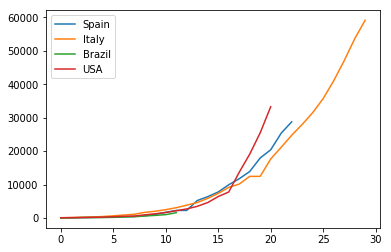

In [6]:
# plot series
for i in allSeries:
    plt.plot(allSeries[i], label=i)
plt.legend()

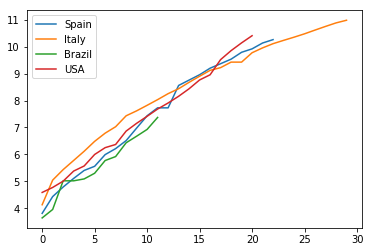

In [7]:
# convert a series into log values
def logSeries(series):
    return [math.log(i) for i in series]

# plot series in log scale
for i in allSeries:
    plt.plot(logSeries(allSeries[i]), label=i)
plt.legend()

In [8]:
# search for best set of parameters for each time-series (only linear regressors)
bestParameters = dict()
bestValues = dict()
for alg in [LinearRegression(), Lasso(), LinearSVR(), ElasticNet(), SGDRegressor()]:
    for d in range(1,5):
        model = Pipeline([('poly', PolynomialFeatures(degree=d)), ('linear', alg)])
        for n in range(1,5):
            for i in allSeries:
                error = calculateError(model, allSeries[i], n)
                
                if not i in bestValues or error < bestValues[i]:
                    bestValues[i] = error
                    bestParameters[i] = [model, d, n]

print (bestValues, bestParameters)

{'Spain': 956.4088014986144, 'Italy': 753.1722613286529, 'Brazil': 99.62017129963131, 'USA': 949.412102002607} {'Spain': [Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]), 1, 1], 'Italy': [Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]), 1, 1], 'Brazil': [Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('linear', LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0))]), 1, 3], 'USA': [Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=1, inc

In [9]:
# training a model with best parameters for each time-series
def trainBestModel(series, parameters):
    model = parameters[0]
    d = parameters[1]
    n = parameters[2]
    
    x = prepareTrain(series, n)
    
    points = []
    train_data = []
    train_label = []
    for i in range(len(x) - 1):
        train_data.append(x[i,:n])
        train_label.append(x[i,n])
        
        reg = model.fit(train_data, train_label)
        yPred = reg.predict([x[i + 1,:n]])[0]
        points.append(yPred)
    
    reg = model.fit(train_data, train_label)
    yPred = reg.predict([series[::-1][:n]])[0]
    points.append(yPred)
    
    return points

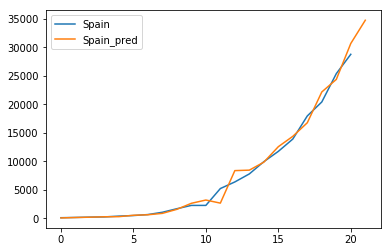

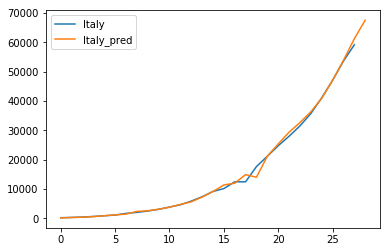

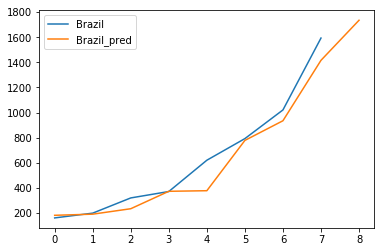

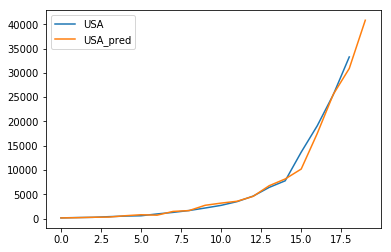

Predictions for 22/3:

Spain : 34738
Italy : 67520
Brazil : 1735
USA : 40826


In [10]:
# compare prediction and real data
nextDayPredictions = dict()
for i in allSeries:
    n = bestParameters[i][2]
    plt.plot(allSeries[i][(n + 1):], label=i)
    predSeries = trainBestModel(allSeries[i], bestParameters[i])
    plt.plot(predSeries, label=(i + "_pred"))
    plt.legend()
    plt.show()
    nextDayPredictions[i] = predSeries[-1]
    
# print predictions for the next day
print ("Predictions for 22/3:\n")
for i in allSeries:
    print (i, ":", int(round(nextDayPredictions[i])))